## The Street View House Numbers (SVHN) Using ResNet

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

Using cuda device


**Download DataSet** 

In [24]:
#use gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

#transformations for the data set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#load the data
data_path = 'path_to_data'
train_data = datasets.SVHN(root=data_path, split='train', download=True, transform=train_transform)
test_data = datasets.SVHN(root=data_path, split='test', download=True, transform=test_transform)


Using device: cuda
Using downloaded and verified file: path_to_data\train_32x32.mat
Using downloaded and verified file: path_to_data\test_32x32.mat


**Data Preprocessing and Augmentation**


In [25]:

# חלוקה לסט אימון וולידציה
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_data)}")


Training images: 58605
Validation images: 14652
Test images: 26032


**ResNet Model**

C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Train Loss: 0.6573, Train Accuracy: 79.08%, Validation Loss: 0.4403, Validation Accuracy: 87.37%
Epoch 2/30, Train Loss: 0.3702, Train Accuracy: 88.79%, Validation Loss: 0.3817, Validation Accuracy: 88.70%
Epoch 3/30, Train Loss: 0.2951, Train Accuracy: 91.13%, Validation Loss: 0.3242, Validation Accuracy: 90.43%
Epoch 4/30, Train Loss: 0.2513, Train Accuracy: 92.38%, Validation Loss: 0.2902, Validation Accuracy: 92.01%
Epoch 5/30, Train Loss: 0.2190, Train Accuracy: 93.45%, Validation Loss: 0.2897, Validation Accuracy: 91.51%
Epoch 6/30, Train Loss: 0.1969, Train Accuracy: 93.97%, Validation Loss: 0.2756, Validation Accuracy: 92.44%
Epoch 7/30, Train Loss: 0.1779, Train Accuracy: 94.47%, Validation Loss: 0.2705, Validation Accuracy: 92.46%
Epoch 8/30, Train Loss: 0.1637, Train Accuracy: 94.88%, Validation Loss: 0.2805, Validation Accuracy: 92.45%
Epoch 9/30, Train Loss: 0.1460, Train Accuracy: 95.45%, Validation Loss: 0.2902, Validation Accuracy: 91.71%
Epoch 10/30, Train 

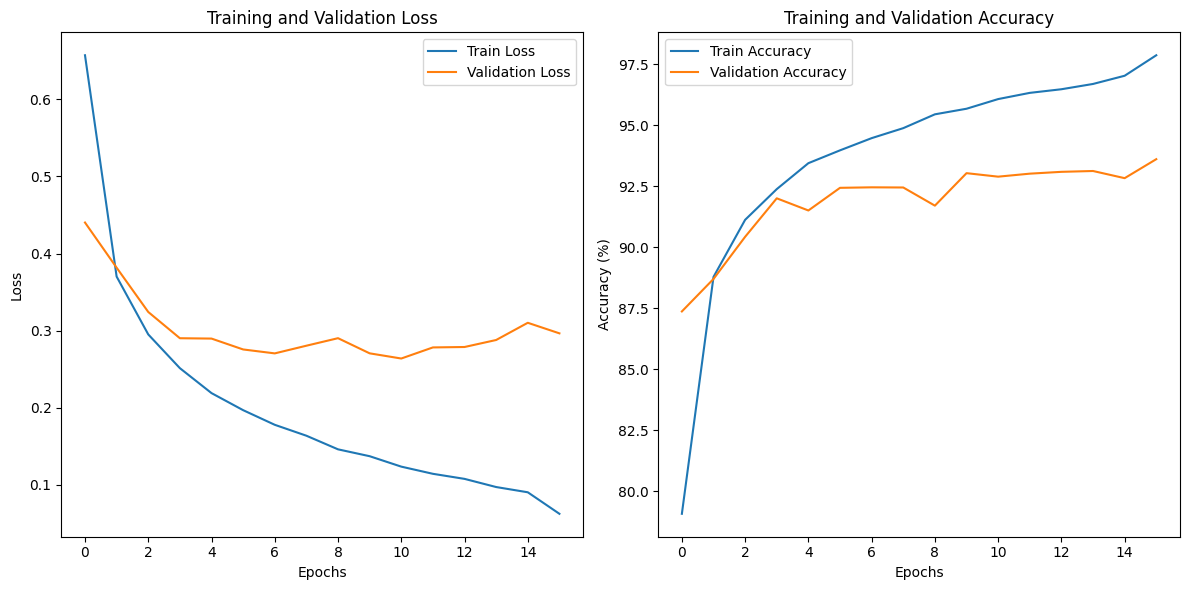

In [29]:
#calculate class weights for the loss function based on the training data distribution
class_counts = Counter(train_data.labels)
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(10)]
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))

num_classes = 10
model = resnet50(weights=ResNet50_Weights.DEFAULT) # will use resnet50 pre-trained on ImageNet
model.fc = nn.Linear(model.fc.in_features, num_classes) # change the output layer to have 10 classes
model = model.to(device) # move the model to the gpu

# freeze all layers except the last one 
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

#optimizer and learning rate scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

#train the model
num_epochs = 30
patience = 5
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []
train_acc_history, val_acc_history = [], []  # הוספת היסטוריות דיוק

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_acc_history.append(train_accuracy)  

   #validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early Stopping if not improving 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "resnet50_svhn_best.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

#Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\lidor\AppData\Local\Temp\ipykernel_43784\2566165645.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet50_svhn_best.pth"))


Test Loss: 0.2098, Test Accuracy: 94.27%


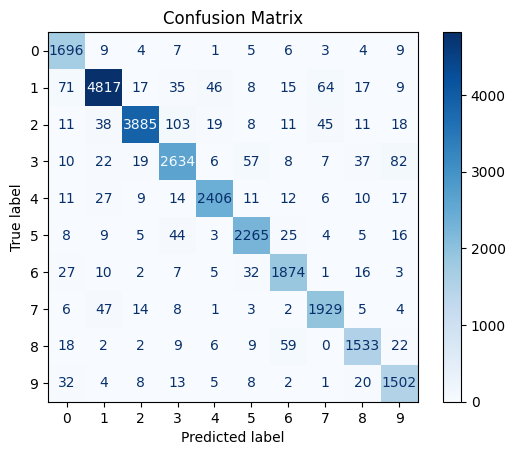

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1744
           1       0.97      0.94      0.96      5099
           2       0.98      0.94      0.96      4149
           3       0.92      0.91      0.92      2882
           4       0.96      0.95      0.96      2523
           5       0.94      0.95      0.95      2384
           6       0.93      0.95      0.94      1977
           7       0.94      0.96      0.95      2019
           8       0.92      0.92      0.92      1660
           9       0.89      0.94      0.92      1595

    accuracy                           0.94     26032
   macro avg       0.93      0.94      0.94     26032
weighted avg       0.94      0.94      0.94     26032



In [30]:
#load the model and evaluate on the test set
model.load_state_dict(torch.load("resnet50_svhn_best.pth"))
model.eval()

test_loss, correct, total = 0.0, 0, 0
all_labels, all_predictions = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

#plot the confusion matrix and classification report
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_predictions))



# Comparison of ResNet and Custom CNN

**Introduction**

This report compares a pre-trained **ResNet50** model using transfer learning and a custom **CNN** trained from scratch. The focus is on **accuracy**, **training time**, and challenges in classifying numbers in the **SVHN** dataset.

---

**Results**

**ResNet50 Model**
- **Accuracy:** 94.27%
- **Test Loss:** 0.2098
- **Challenges:** Class **9** was harder to classify, even with weighted loss applied.
- **Training Time:** ~2 hours on a powerful GPU.

**Custom CNN Model**
- **Accuracy:** 91.18%
- **Test Loss:** 0.3093
- **Challenges:** Class **9** showed lower precision and recall compared to other classes.
- **Training Time:** ~30 minutes, much faster than ResNet on the same GPU.

---

**Conclusions**

- **ResNet50 Advantages:** Higher accuracy and better performance, especially in more complex classes.
- **Custom CNN Advantages:** Faster training and reasonable accuracy, making it suitable for quick iterations.
- **Class 9 Issue:** Both models struggled with class **9**, likely due to fewer samples or visual similarity to other digits.
- **Improvement Opportunities:** Weighted loss helped slightly, but better data balance or advanced augmentations could further improve performance.

---

**Summary**

ResNet50 is better for accuracy and handling complex classes, while the custom CNN is faster and more efficient. Both models require additional strategies to improve performance on class **9**.

---
